## Unit 3 Laboratory Assignement

In [100]:
import numpy as np

import pymc3 as pm

from scipy.stats import norm, pearsonr, sem
from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [103]:
def compute_sigmoid(x):
    """
    Compute the sigmoid transformation of x
    """
    return 1 / (1 + np.exp(-x))

def compute_posterior(prior, likelyhood, comp_likelyhood):
    """
    Compute posterior for simple binary case
    """
    first_term = (likelyhood * prior)
    second_term = (
        (likelyhood * prior) + (comp_likelyhood * (1 - prior))
    )
    posterior = first_term / second_term
    return posterior

def compute_BIC(n, eta_sq, k1, k0):
    """
    Compute ΔBIC
    """
    bic = n * np.log(1 - eta_sq)+(k1 - k0)*np.log(n)
    return bic

def compute_BF01(bic, return_posterior=True):
    """
    Compute BF01 from ΔBIC
    """
    bf01 = np.exp(bic / 2)
    if return_posterior:
        posterior = bf01 / (bf01 + 1)
        return bf01, posterior
    return bf01

def compute_posterior_normal(prior_mu, prior_sigma, sample_size, pop_mu=3, 
                             pop_sigma=10):
    """
    Python port of ill_posterior_maria
    Matlab script provided during the course
    
    We will cheat a bit using PyMC3
    """
    data = pop_mu + np.sqrt(pop_sigma) * np.random.normal(0, 1, sample_size)
    
    with pm.Model() as normal_model:
        
        
        mu = pm.Normal(
            mu=prior_mu,
            sigma=np.sqrt(prior_sigma),
            name='Mu'
        )
        posterior = pm.Normal(
            mu=mu,
            sigma=np.sqrt(pop_sigma),
            name='Observation',
            observed=data
        )
        
        trace = pm.sample(cores=1)
    
    return trace['Mu']

def plot_posterior_normal(posterior, sample_size, 
                          prior_mu, prior_sigma, 
                          pop_mu, pop_sigma):
    """
    Plot a desnity plot of the posterior
    with all the relevant information
    """
    mu = round(np.mean(posterior), 2)
    std = round(np.std(posterior), 2)
    lower = round(np.percentile(posterior, 2.5), 2)
    upper = round(np.percentile(posterior, 92.5), 2)
    
    plt.figure(figsize=(5, 5))
    sns.kdeplot(
        posterior,
        label=f'Mu: {mu} \n Std: {std}'
    )
    
    text_info = f"""
        Prior Mu: {prior_mu} \n
        Prior Std: {round(np.sqrt(prior_sigma), 2)} \n
        Posterior Mu: {mu} \n
        Posterior Std: {std}
    
    """

    plt.text(
        .9, 
        0.3, 
        text_info, 
        fontsize=14, 
        transform=plt.gcf().transFigure
    )
    
    plt.axvline(lower, c='r', linestyle='--')
    plt.axvline(upper, c='r', linestyle='--')
    plt.title(
        f'Sample N {sample_size} Mu {round(pop_mu, 2)} Std {round(np.sqrt(pop_sigma), 2)}'
    )
    plt.xlabel('Posterior Mu')
    plt.legend()
    plt.show()
    
    return None

def plot_traces(trace, variables):
    """
    Quick and dirty traceplot
    """
    fig, axs = plt.subplots(len(variables), 1, figsize=(10, 5*len(variables)))
    for variable, ax in zip(variables, axs.flatten()):
        
        autcorr = acf(trace[variable], nlags=6)[1:]
        text_info = f"""
        Lag 1: {autcorr[0]} \n
        Lag 2: {autcorr[1]} \n
        Lag 3: {autcorr[2]} \n
        Lag 4: {autcorr[3]} \n
        Lag 5: {autcorr[4]}
        """
        
        ax.plot(trace[variable], label=text_info)
        ax.set_title(variable)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_predictions(predictors, traces, ground_truths):
    """
    """
    plt.figure(figsize=(10, 5))
    rescaled_predictors = (predictors - predictors.mean()) / predictors.std()
    for rescaled_predictor, predictor, ground_truth in zip(rescaled_predictors, predictors, ground_truths):
        
        prediction = compute_sigmoid(
            trace['Intercept'] + trace['Slope']*rescaled_predictor
        )
        
        lower = np.percentile(prediction, 2.5)
        upper = np.percentile(prediction, 92.5)
        
        plt.scatter(
            predictor,
            prediction.mean(),
            c='b',
            alpha=0.25
        )
        plt.errorbar(
            predictor,
            prediction.mean(),
            yerr=prediction.std() * 2, # we assume normally distributed posterior 
            c='b',
            alpha=0.25
        )
        
        plt.scatter(
            predictor,
            ground_truth,
            c='r'
        )
    
    plt.xlabel('Predictor')
    plt.ylabel('Probability of Failure')
    plt.legend(
        handles=[
            mpatches.Patch(color=color, label=label) for color, label in zip(['r', 'b'], ['Ground Truth', 'Prediction'])
        ]
    )
    plt.show()

### Bayes Rule

In the example from the slides about the genetic status of the woman, we obtained a posterior probability of P(woman is a carrier | two sons not affected) = P(θ = 1|y =0)  = 0.20.  Note, we can summarise the previous data y1=0, y2=0 by simply writing y=0 in the expressionabove.

### Question 1.1
Consider now the following additional information:The woman has a third son who is also not affected by hemophilia. 

Using 0.20 as our updated prior on the status of the woman, i.e. now P(θ = 1) = 0.20, use Bayes' rule to estimate the new posterior probability on the woman status. Is the woman a carrier of hemophilia gene? P(θ = 1|y3 = 0)? With y3= 0 being the new evidence gathered from the third son

In [5]:
posterior = compute_posterior(
    prior=0.2, 
    likelyhood=0.5, 
    comp_likelyhood=1
)
print(f'Posterior: {posterior}')

Posterior: 0.11111111111111112


### Question 1.2

Start from the beginning by estimating sequentially the posterior probability of the woman being a carrier of the affected X chromosome and using that posterior probability as prior (a in function Bayes(a,b,c). Use b as the probability that her first son is not affected, then that the second son is not affected and, finally, that the third son is not affected.Do you obtain the same result as in Question 1.1.

In [6]:
prior = 0.5
for child, likelyhood in enumerate([0.5]*3):
    
    posterior = compute_posterior(
        prior=prior, 
        likelyhood=likelyhood, 
        comp_likelyhood=1
    )
    prior = posterior
    print(f'Posterior after obseving child {child}')
    print(posterior)

Posterior after obseving child 0
0.3333333333333333
Posterior after obseving child 1
0.19999999999999998
Posterior after obseving child 2
0.1111111111111111


### Question 1.3

What is the posterior on the woman status if the third son is affected by hemophilia?  P(θ = 1|y3 = 1)?

In [7]:
posterior = compute_posterior(
    prior=0.2, 
    likelyhood=0.5, 
    comp_likelyhood=0.5
)
print(f'Posterior: {posterior}')

Posterior: 0.2


Compute Bayes factor using Bayes rule for discrete variables in the following example.  
  
To facilitate early detection of breast cancer, women are screened using mammography, even if they have no obvious symptoms.  
Consider the following information:
  
Notation.  
  
θ  is the hidden parameter (status of a woman, cancer [θ =1] or no cancer [θ =0])  
Y is the data (mammography test is positive [Y=1] or negative [Y=0]). 
  
P(θ): The probability that one of these women has breast cancer is 1/100.  
P(Y = 1 | θ  = 1): If a woman has breast cancer, the probability is 80/100 that she will have a positive test.   
P(Y = 1 | θ  = 0): If a woman does not have breast cancer, the probability is 9.6/100 of a positive test.  

### Question 2

If a woman with no symptoms shows positive in mammography test, what is the probability that she actually has breast cancer? What is the posterior distribution p(θ  = 1|Y = 1) ? 

In [8]:
posterior = compute_posterior(
    prior=0.01, 
    likelyhood=0.8, 
    comp_likelyhood=0.096
)
print(f'Posterior: {posterior}')

Posterior: 0.07763975155279504


## Bayes Factor

Here we will use Bayesian analysis following the method proposed by Masson (2011) to disentangle which model (null vs alternative hypothesis) is more strongly supported by the available data.  
  
Within this framing, the posterior probability that the data favor the alternative hypothesis, i.e.,pBIC(H1|D), ranges from 0 to 1 and is just the complement of the posterior probability that the data favor the null hypothesis.  
  
Thus, pBIC(H1|D) > 0.50 indicates that there is more evidence for the alternative than for the null hypothesis, whereas values <0.50 indicate the opposite.  
  
The first step in the computation is estimating the Bayes factor BF01.  
  
Following Wagenmakers (2007), Masson (2011) describes one approach to estimating BF01 that is based on the Bayesian Information Criterion, or BIC. 

BF01~e(ΔBIC/2)                                                                                  
ΔBIC=nln (1−ηp2)+(k1−k0)ln(n).   
  
In Equation (2), n represents the number of subjects, ηp2 is the standard effect size measure in an ANOVA which represents the proportion of variance accounted for by the independent variable, and k1 − k0 represents the difference in the number of free parameters between the two models being compared.  
  
Note that in the case of a comparison 
between a null and alternative hypothesis for a single two-level factor (i.e., prime, present vs. absent), k1 − k0 = 1. Finally, if we assume that the null and alternative hypothesis are equally likely before collecting data (that is, equal priors), the Bayes factor B01 can be converted into aposterior probability estimate via the equation:p(H0|D) =  BF01 / ( BF01 + 1).   

### Question 3

Estimate Bayes factor, the probability for the null, p(H0|D),  and the alternative, p(H1|D),  hypotheses in the following experiments. Discuss.


(I) Experiment 1, the authors reported that for the n = 18 patients with schizophrenia, the critical interaction of response and orientation did not differ as a function of name prime (present vs. absent), F(1, 17) = 2.584, p = 0.126, ηp2 =0.13

In [15]:
bic = compute_BIC(n=18, eta_sq=0.13, k1=2, k0=1)
bf01, posterior = compute_BF01(bic)
print(f'BIC: {bic}')
print(f'BF01: {bf01}')
print(f'p(H0|D): {posterior}')
print(f'p(H1|D): {1 - posterior}')

BIC: 0.3836545458930267
BF01: 1.2114612467605417
p(H0|D): 0.5478102989754626
p(H1|D): 0.45218970102453737


(II) A similar computation can be carried out for the effect of action prime in Experiment 2. Sevos et al (2016) report that for a group of n = 18 patients with schizophrenia, the interaction between response and orientation did not differ as a function of action prime (congruent vs. incongruent), F(1, 17) = 1.288, p = 0.272, ηp2=0.07.

In [16]:
bic = compute_BIC(n=18, eta_sq=0.07, k1=2, k0=1)
bf01, posterior = compute_BF01(bic)
print(f'BIC: {bic}')
print(f'BF01: {bf01}')
print(f'p(H0|D): {posterior}')
print(f'p(H1|D): {1 - posterior}')

BIC: 1.5840992868691255
BF01: 2.2079172347147655
p(H0|D): 0.6882712592524489
p(H1|D): 0.3117287407475511


# Estimating a normal mean with known variance

### Question 4.1. 

Use the code to compute the posterior mean, std and the lower/upper boundaryof 95% of the highest posterior density interval in each case of sample size.Change the code to extract these values as output for each sample size (mu1, alpha21, lowerB,upperB)

### Question 4.2.

Discuss how the posterior distribution (mean, std) is affected if we modify in ill_priorposterior_maria the following:- prior distribution Change the hyperparameters mu0 = 0; alpha20 = 1/4; to other valuesalpha20 = 1 (larger variance, smaller precision in the prior)alpha20 = 1/16 (smaller variance, smaller precision in the prior)In each case, compare what happens if we use n = 1 data points, and n = 32 data points.- likelihood /data distributionOriginal parameters should be muTrue = 3, sigma = 1. Change the std sigma = 1 to other values (keep muTrue the same),   muTrue = 3, sigma = 1/4muTrue = 3, sigma = 4

In [3]:
sample_sizes = [1, 2, 4, 8, 16, 32]
prior_sigmas = [1/4, 1, 1/16]
pop_sigmas = [10, 1, 1/4, 4]

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '17392' (I am process '5548')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


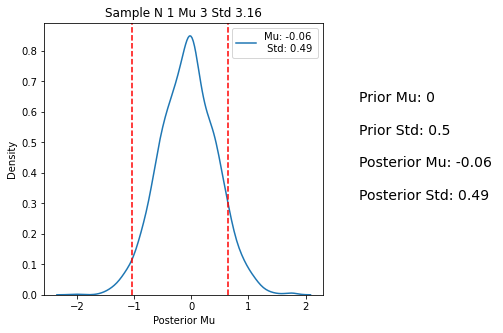

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


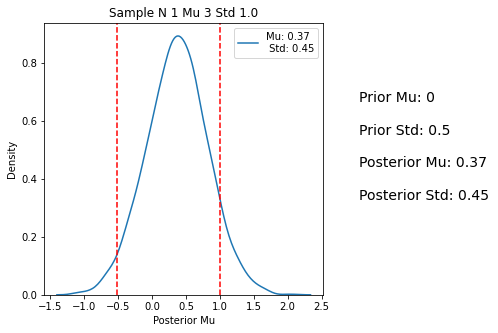

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


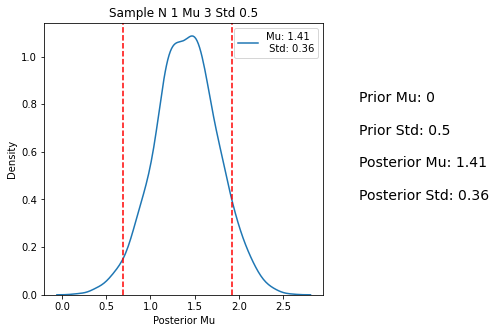

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


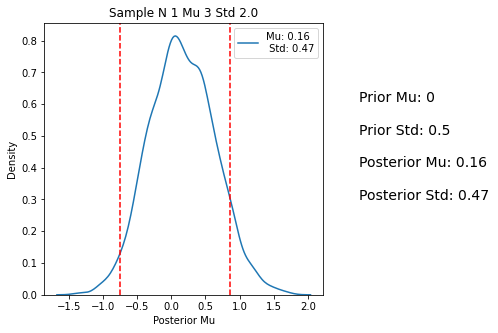

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


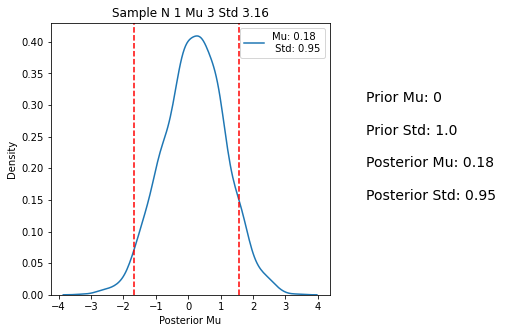

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


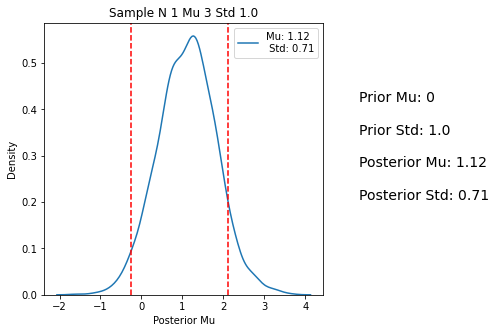

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


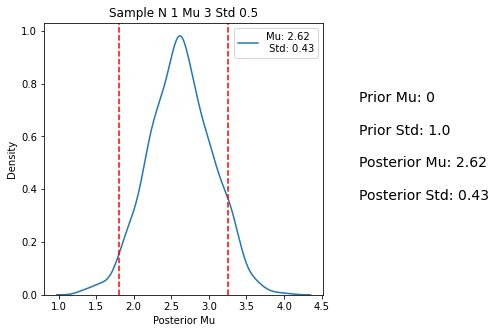

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


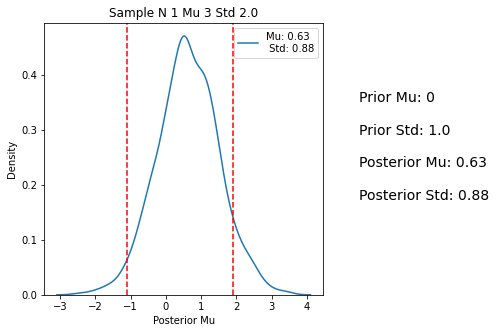

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


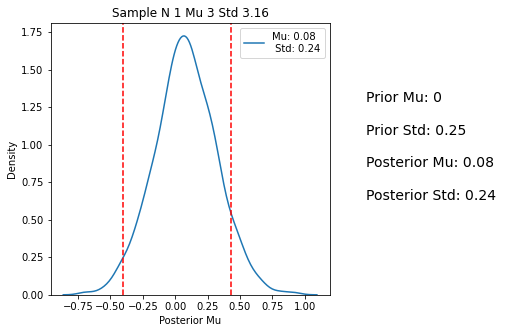

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


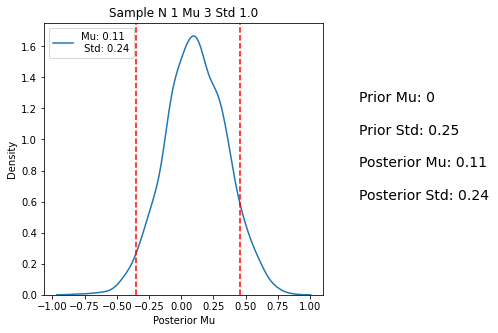

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


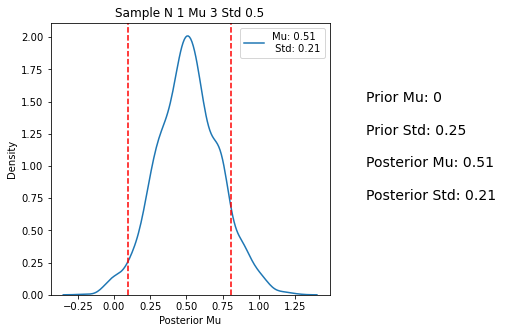

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


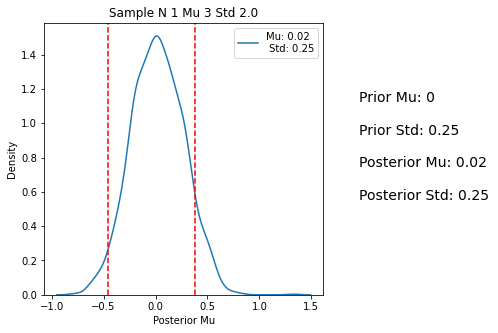

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


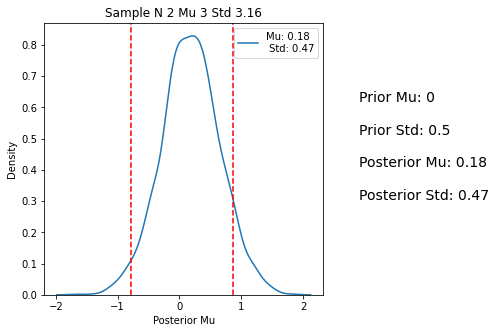

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


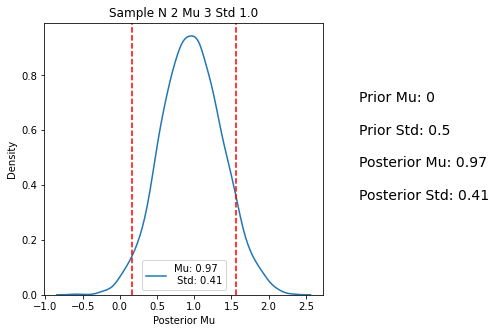

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


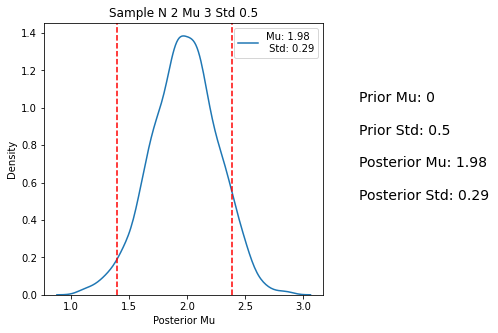

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


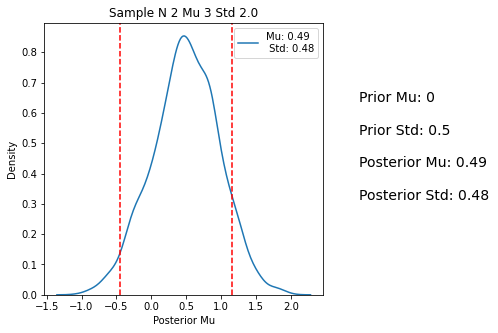

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


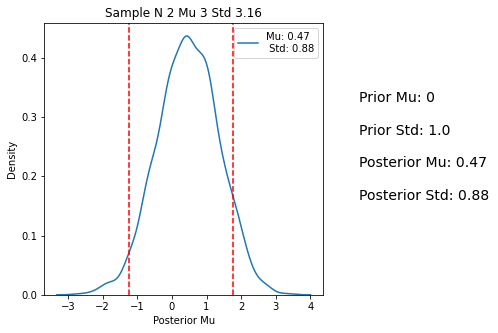

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


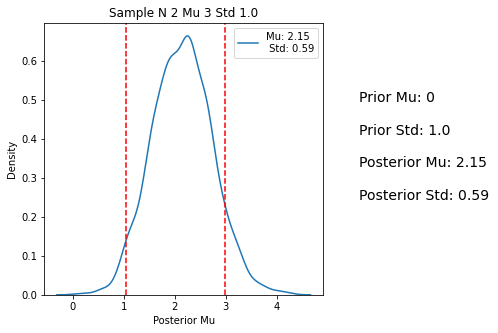

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


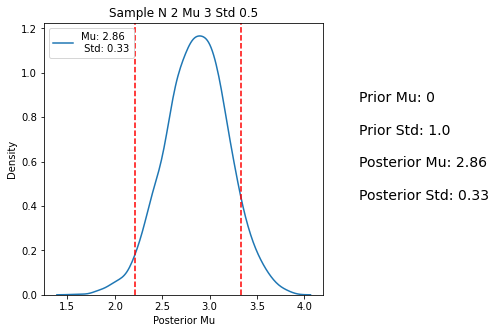

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


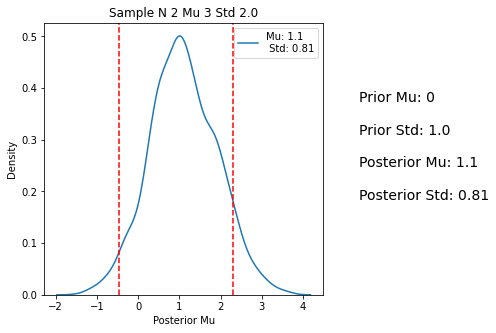

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


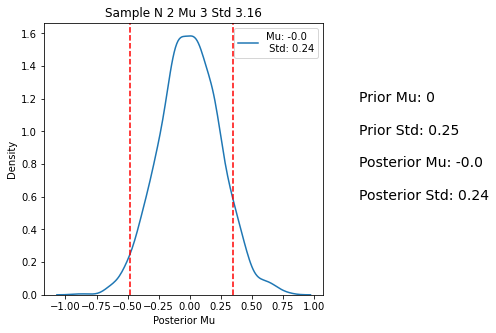

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


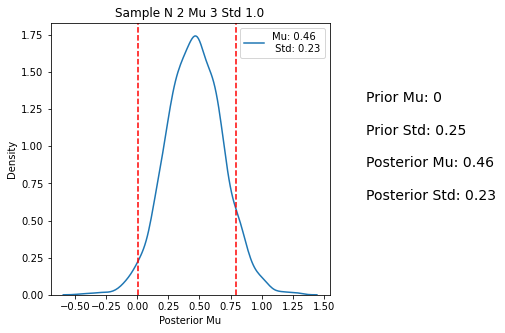

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


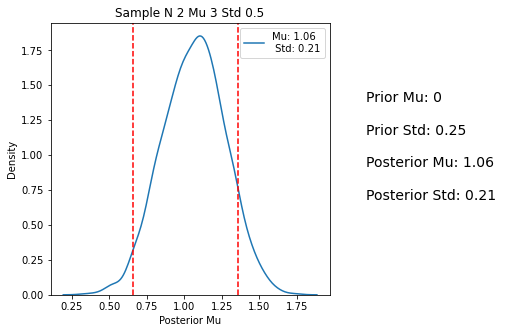

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


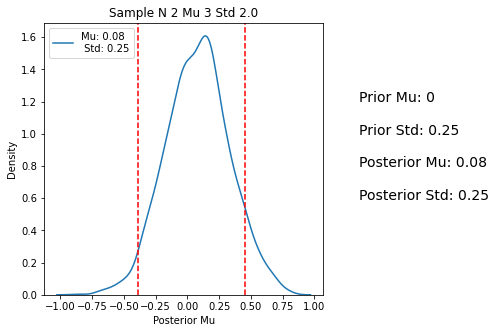

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


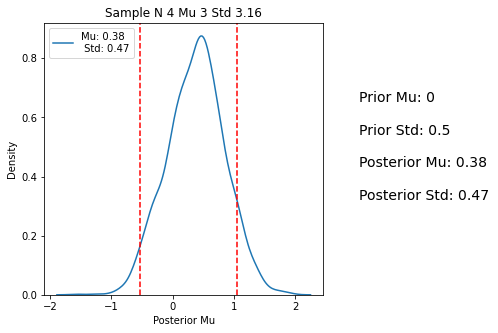

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


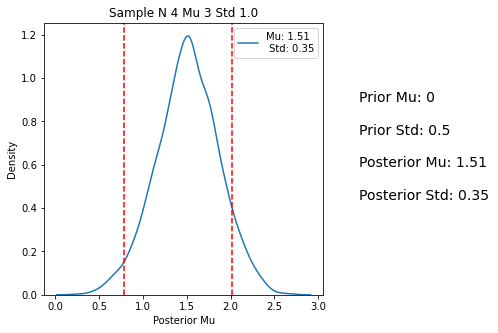

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


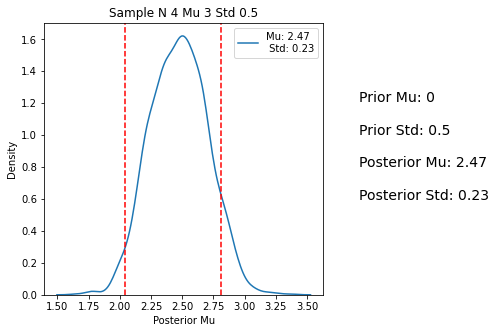

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


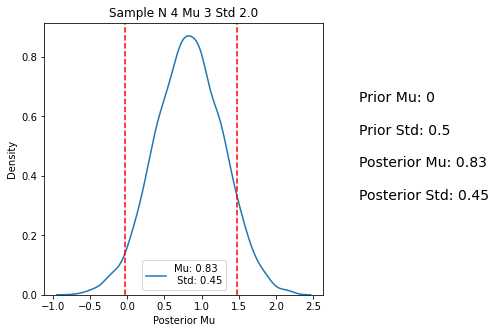

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


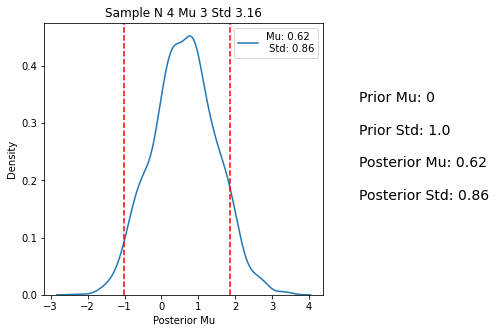

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


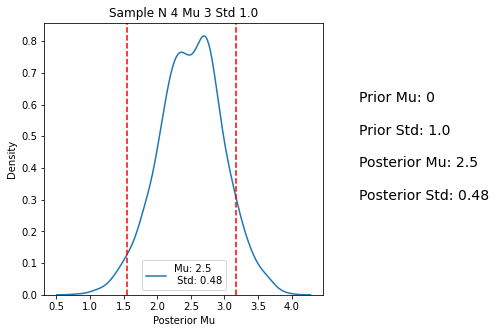

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


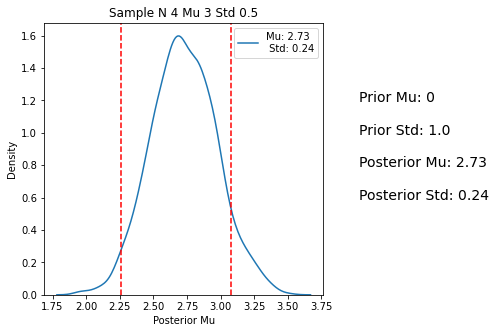

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


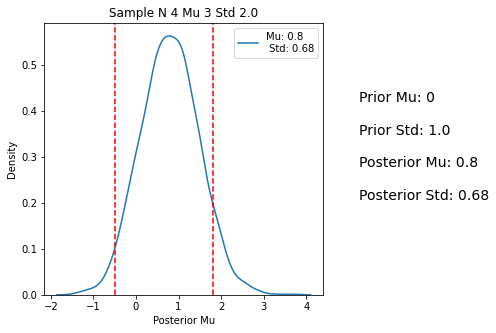

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


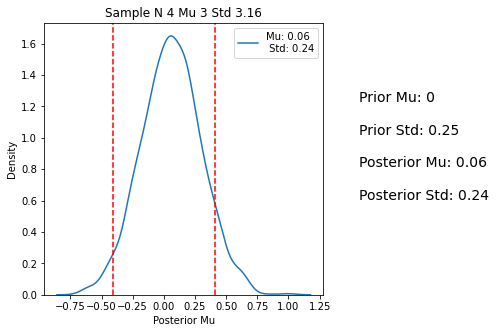

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8875459660442004, but should be close to 0.8. Try to increase the number of tuning steps.


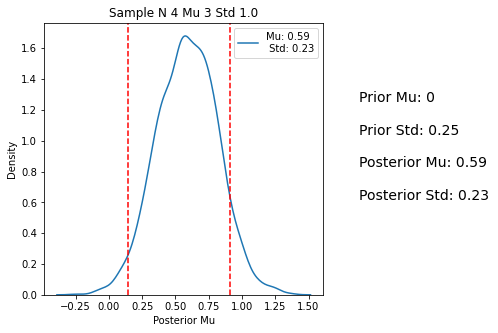

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


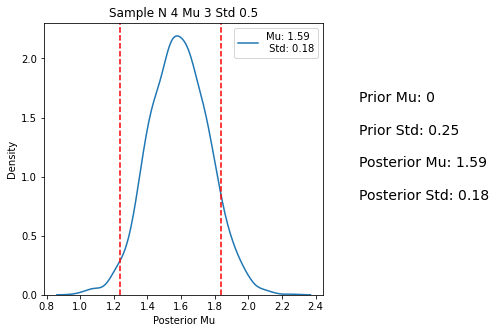

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


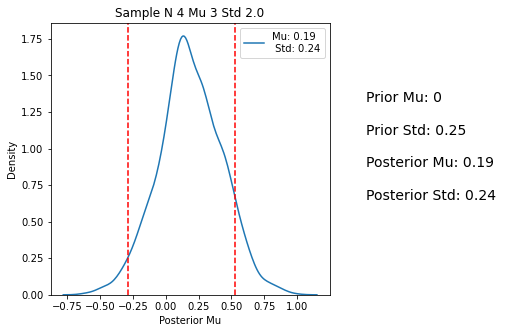

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


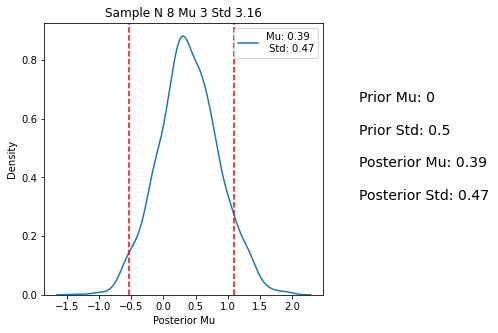

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


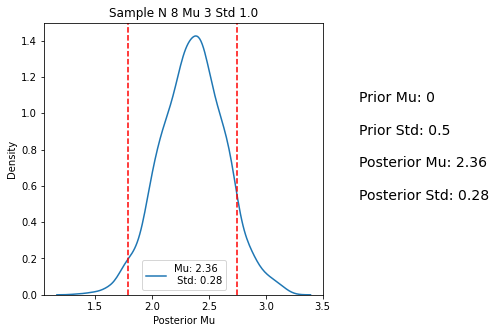

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


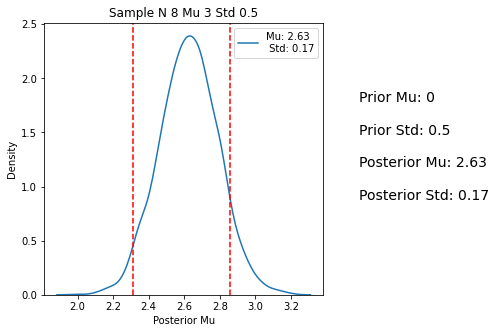

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


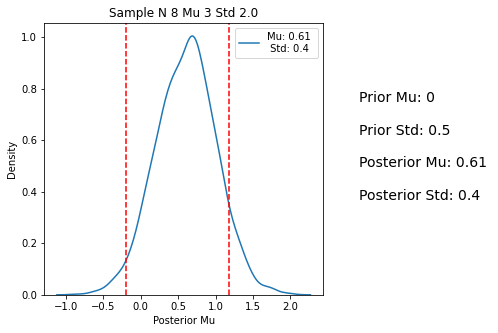

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


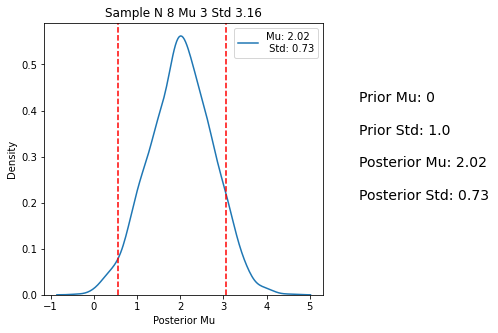

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


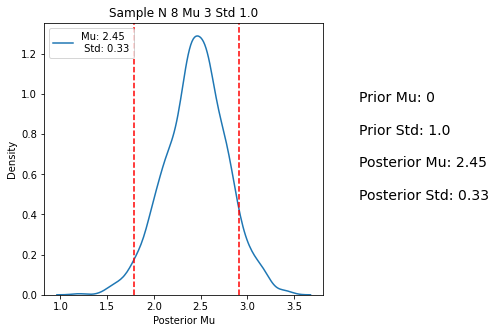

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


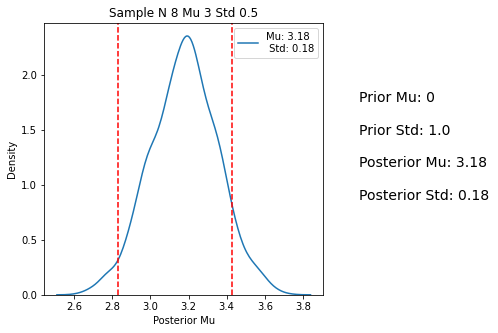

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


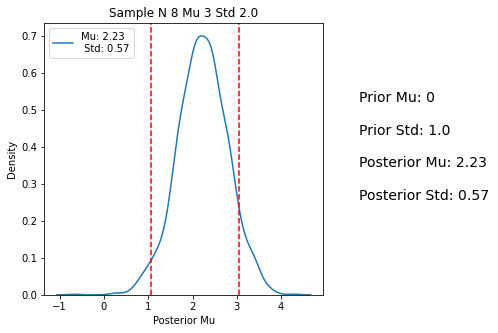

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


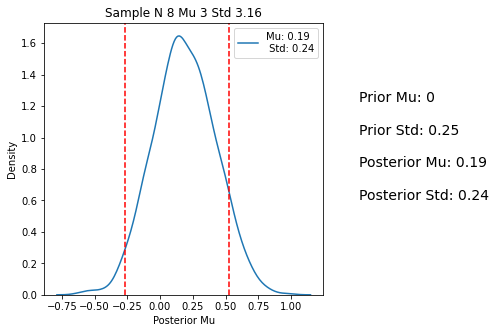

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


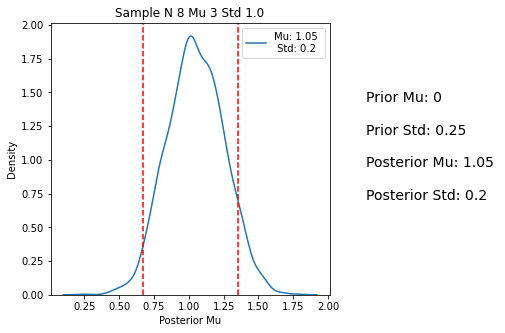

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


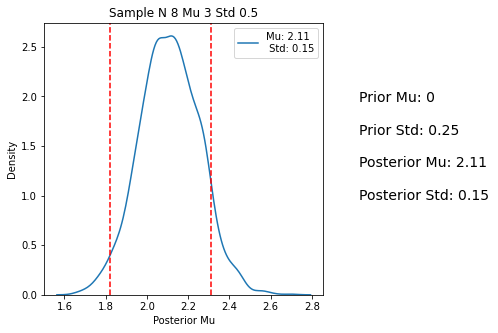

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


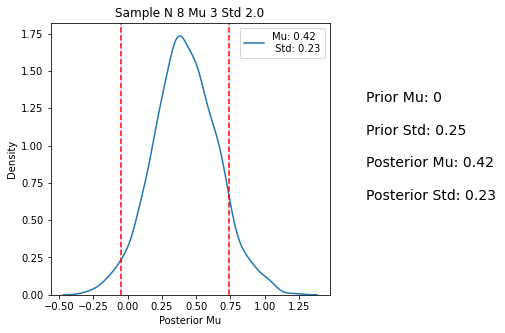

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


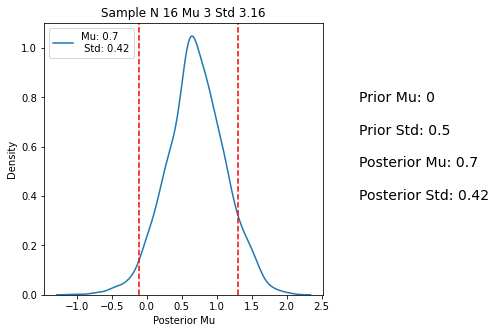

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


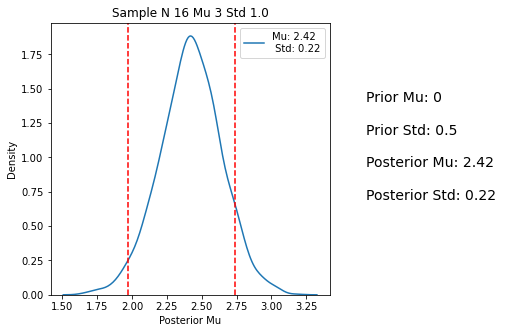

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


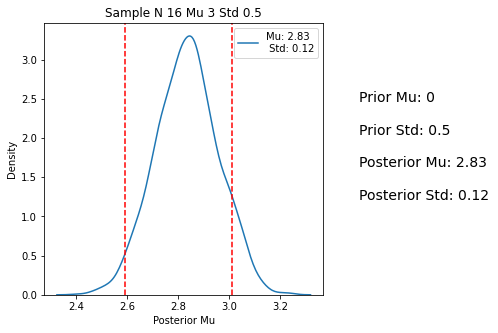

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


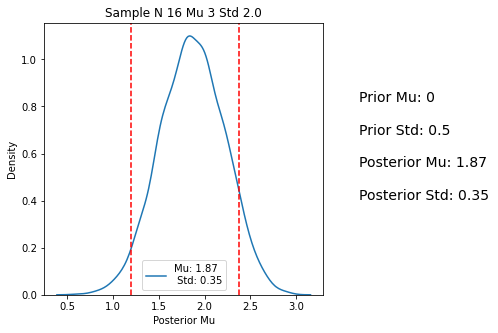

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


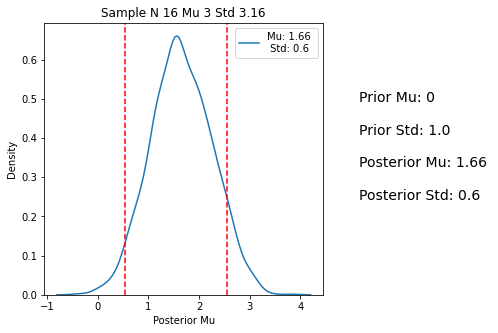

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


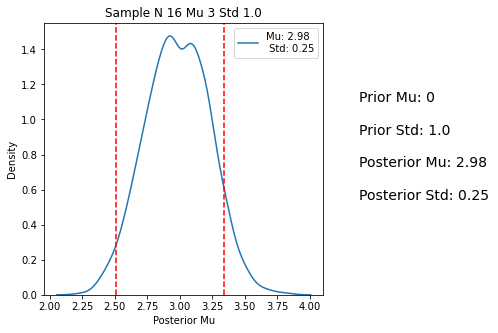

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


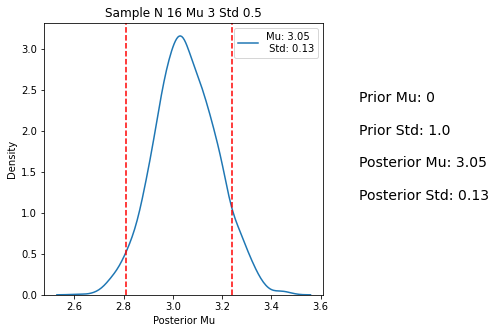

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


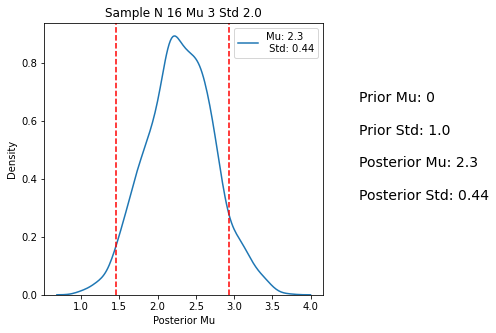

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


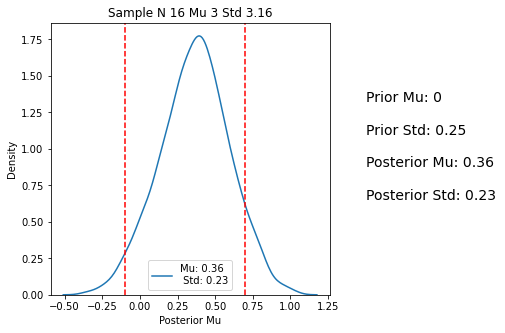

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


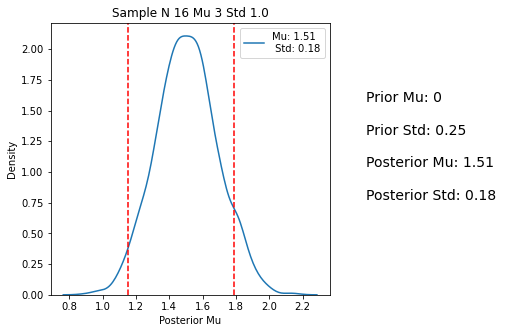

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


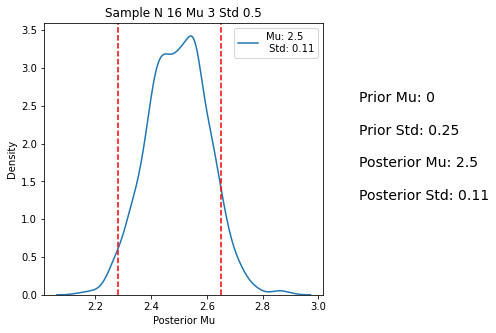

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


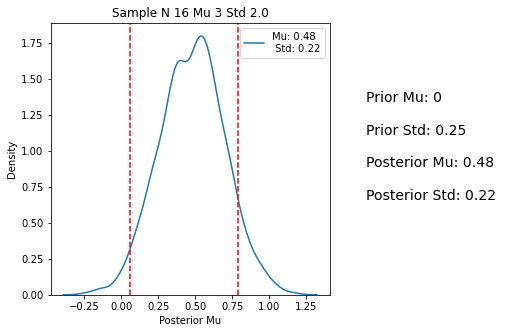

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


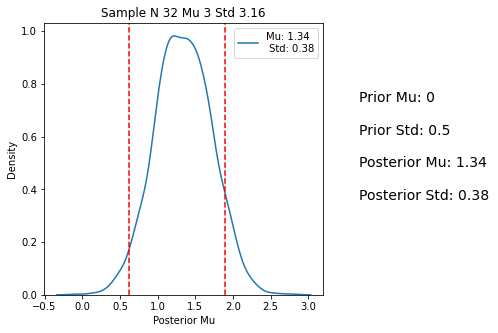

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


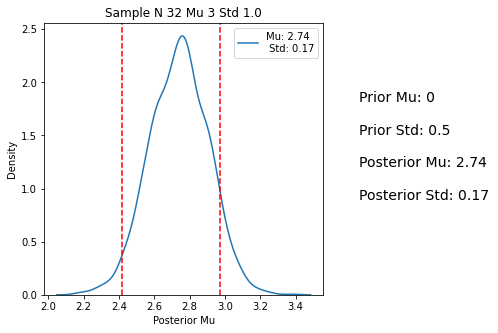

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


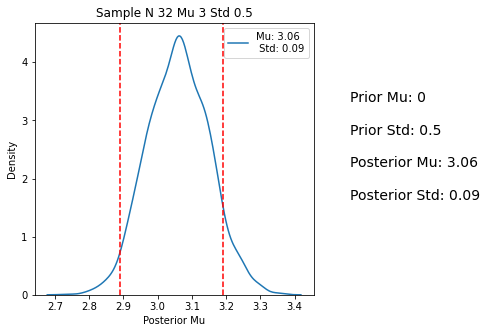

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8878535440467831, but should be close to 0.8. Try to increase the number of tuning steps.


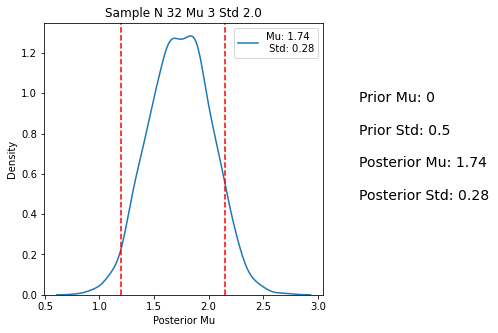

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


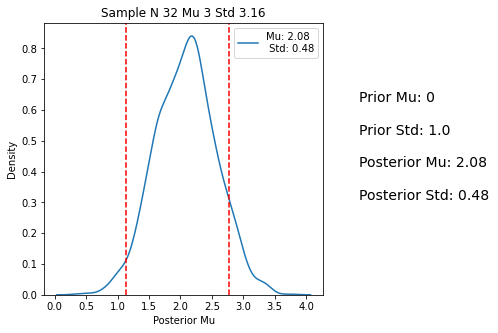

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


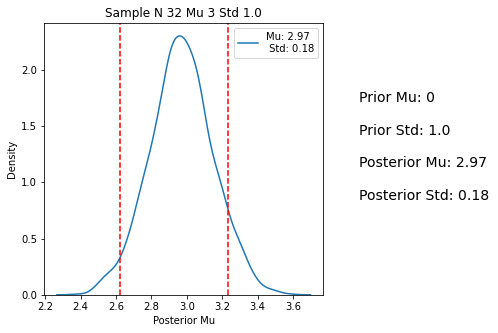

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


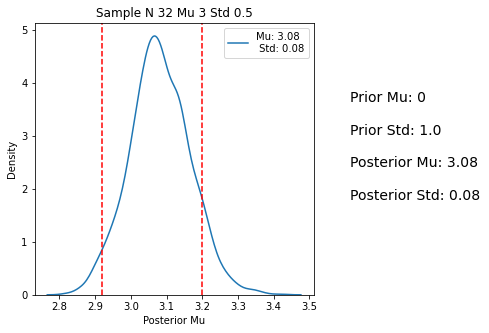

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


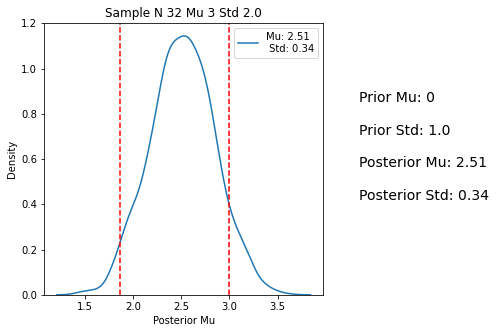

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


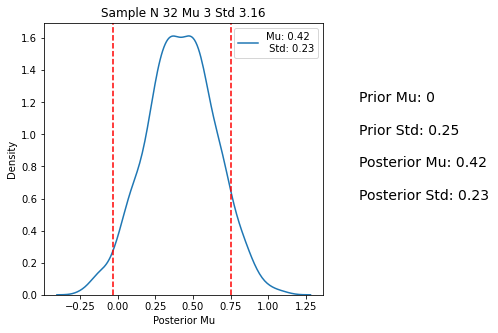

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8920053482582991, but should be close to 0.8. Try to increase the number of tuning steps.


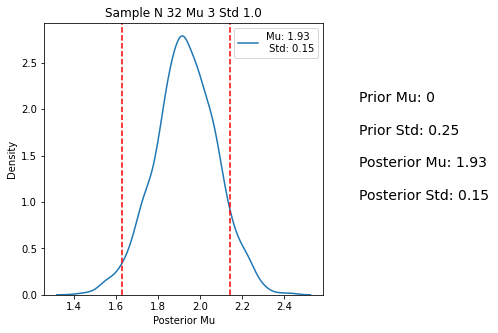

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


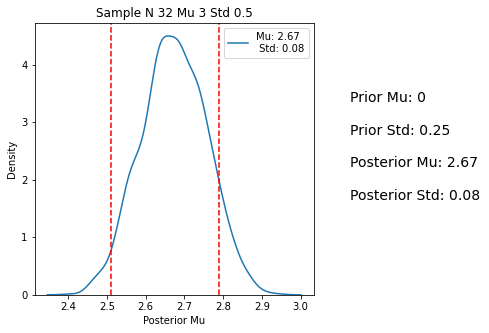

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


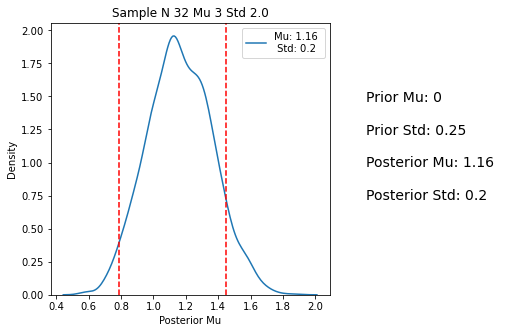

In [4]:
for sample_size in sample_sizes:
    
    for prior_sigma in prior_sigmas:
        
        for pop_sigma in pop_sigmas:

            posterior = compute_posterior_normal(
                prior_mu=0, 
                prior_sigma=prior_sigma, 
                sample_size=sample_size,
                pop_sigma=pop_sigma
            )
            plot_posterior_normal(
                posterior=posterior,
                sample_size=sample_size,
                pop_mu=3,
                pop_sigma=pop_sigma,
                prior_mu=0,
                prior_sigma=prior_sigma
            )

# Bayesian Logistic Regression

In statistics, logistic regression, or logit regression, or logit model is a regression model where the dependent variable (DV) is categorical.  
  
In our example below we covers the case of a binary dependent variable—that is, where it can take only two values, "0" and "1" (failure or success).This example involves an experiment to help model the proportion of cars of various weights that fail a mileage test. The data include observations of weight, number of cars tested, and number failed.

In [8]:
weight = np.array([2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300])

total = np.array([48, 42, 31, 34, 31, 21, 23, 23, 21, 16, 17, 21])
poor = np.array([1, 2, 0, 3, 8, 8, 14, 17, 19, 15, 17, 21])

proportion = poor / total
scaled_weight = (weight - weight.mean()) / weight.std()

In [11]:
with pm.Model() as logistic_model:
    
    intercept = pm.Normal(
        mu=0,
        sigma=20,
        name='Intercept'
    )
    slope = pm.Normal(
        mu=0,
        sigma=20,
        name='Slope'
    )
    
    theta = pm.math.sigmoid(intercept + slope*scaled_weight)
    
    out = pm.Binomial(
        p=theta,
        observed=poor,
        n=total,
        name='Observed'
    )
    
    trace = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Slope, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


### Question 5.1.

Are parameters b1 and b2 correlated? Is the correlation related to the prior or data distributions? Did you initially thought that we had assumed the parameters b1 and b2 were correlated or not?  
  
Plot g2, g3, g4, up to g5. In figure g5 we observe that the samples we took for parameters b1 (intercept) and b2 (slope) were autocorrelated for different time lages.

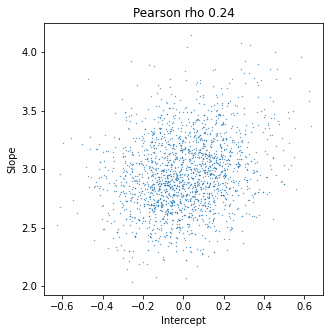

In [21]:
r = round(pearsonr(trace['Intercept'], trace['Slope'])[0], 2)
plt.figure(figsize=(5, 5))
plt.scatter(
    trace['Intercept'],
    trace['Slope'],
    s=0.1
)
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.title(f'Pearson rho {r}')
plt.show()

C:\Users\penthotal\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
C:\Users\penthotal\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


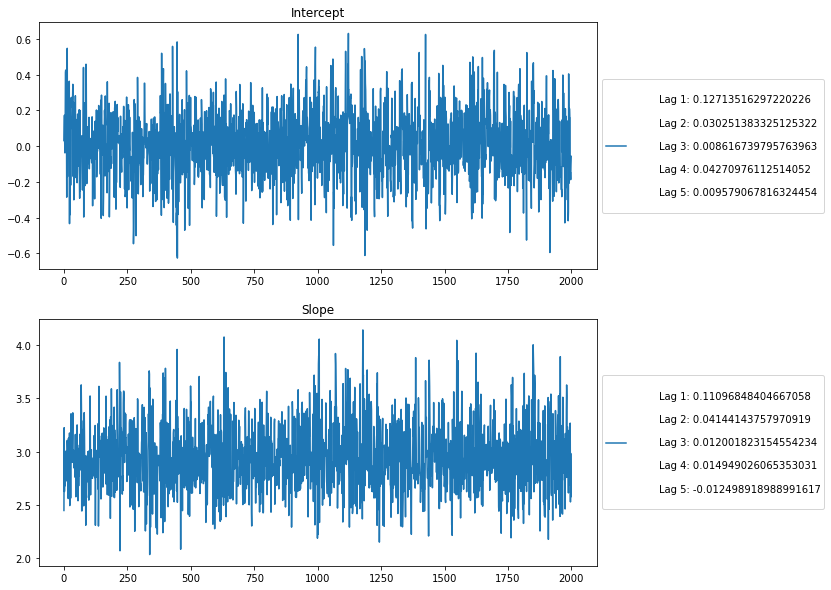

In [49]:
plot_traces(trace, variables=['Intercept', 'Slope'])

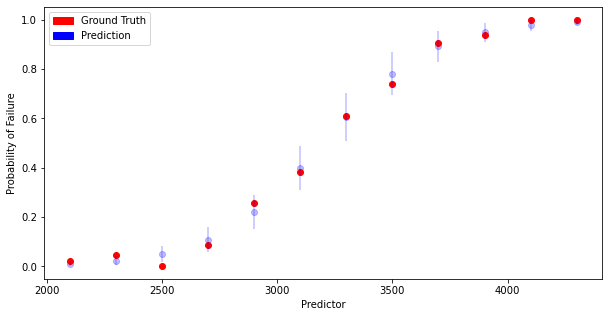

In [104]:
plot_predictions(weight, trace, proportion)